In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import gc

In [2]:
%%time
train = pd.read_feather('/Users/usuario/workspace/AMEX_data/train_data.ftr')
train.head(2)

CPU times: user 16.5 s, sys: 16.2 s, total: 32.6 s
Wall time: 41.4 s


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0


In [3]:
train.shape

(5531451, 191)

In [4]:
%%time
# Conservamos el último registro de cada usuario
df =  (train
            .groupby('customer_ID')
            .tail(1)
            .set_index('customer_ID', drop=True)
            .sort_index()
            .drop(['S_2'], axis='columns'))

CPU times: user 6.91 s, sys: 8.97 s, total: 15.9 s
Wall time: 42.1 s


In [5]:
df.shape

(458913, 189)

In [6]:
all_cols = df.columns.to_list()

cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

num_cols = [col for col in all_cols if col not in cat_cols + ["target"]]

In [7]:
X = df[cat_cols + num_cols]
y = df['target']

X.shape, y.shape

((458913, 188), (458913,))

# Construimos las linea de base

## Partimos el conjunto de datos en train y test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [9]:
print(f'El conjunto de features de entrenamiento tiene la forma: {X_train.shape}')
print(f'El target de testeo tiene la forma: {y_test.shape}\n')
print(f'El conjunto de features de testeo tiene la forma: {X_test.shape}')
print(f'El target de entrenamiento tiene la forma: {y_train.shape}')

El conjunto de features de entrenamiento tiene la forma: (344184, 188)
El target de testeo tiene la forma: (114729,)

El conjunto de features de testeo tiene la forma: (114729, 188)
El target de entrenamiento tiene la forma: (344184,)


## Construimos el pipeline completo en tres pasos.

* Paso 1: definimos los pasos de preprocesamiento
De manera similar a el pipeline agrupa los pasos de preprocesamiento y modelado, usamos la clase ColumnTransformer para agrupar diferentes pasos de preprocesamiento. 

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#El código a continuación imputa valores faltantes en datos numéricos, e
#imputa valores faltantes y aplica una codificación one-hot a los datos categóricos.

# Preprocesando la data numérica
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocesando la data categórica
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

* Paso 2: Definimos el modelo. En este caso para la linea de base utilizaremos una regresión logística

In [11]:
from sklearn.linear_model import LogisticRegression
semilla = 1234
model = LogisticRegression(random_state=semilla, max_iter=200, solver="saga")

* Paso 3: crear y evaluar el pipeline
Finalmente, usamos la clase Pipeline para definir un pipeline que agrupa los pasos de preprocesamiento y modelado. Hay algunas cosas importantes a tener en cuenta:

Con el pipeline, preprocesamos los datos de entrenamiento y ajustamos el modelo en una sola línea de código. (Por el contrario, sin un pipeline, tendríamos que hacer la imputación, la codificación one-hot y el entrenamiento del modelo en pasos separados.

Con el pipeline proporcionamos las funciones no procesadas en X_test al comando predict(), y el pipeline preprocesa automáticamente las funciones antes de generar predicciones. (Sin embargo, sin el pipeline, debemos recordar preprocesar los datos de validación antes de hacer predicciones).

In [12]:
from sklearn.metrics import mean_absolute_error

# Paquete de preprocesamiento y código de modelado
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocesamiento de datos de entrenamiento, ajuste del modelo
my_pipeline.fit(X_train, y_train)

# Preprocesamiento de datos de validación, obtener predicciones
preds = my_pipeline.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,preds)
print(cm)
print(f'El accuracy score para el modelo base es: {accuracy_score(y_test, preds)}')

[[80380  4642]
 [ 9623 20084]]
El accuracy score para el modelo base es: 0.8756635201213294


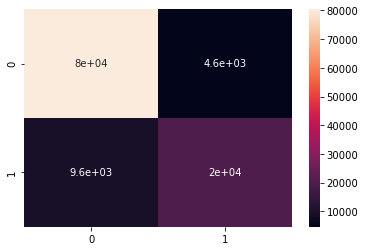

In [14]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     85022
           1       0.81      0.68      0.74     29707

    accuracy                           0.88    114729
   macro avg       0.85      0.81      0.83    114729
weighted avg       0.87      0.88      0.87    114729



## Probamos otros modelos
Probaremos una serie de modelos con sus parametros por defecto, sin tuning:

* Decision tree: un árbol de decisión.

* Extra trees: Un clasificador de árboles adicionales. Esta clase implementa un meta estimador que se ajusta a una serie de árboles de decisión aleatorios en varias submuestras del conjunto de datos, y utiliza el promedio para mejorar la precisión predictiva y controlar el ajuste excesivo.

* Random Forest: Un Random Forest es un conjunto (ensemble) de árboles de decisión combinados con bagging. Es una combinación de árboles predictores tal que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos.

* AdaBoost: consiste en crear varios predictores sencillos en secuencia, de tal manera que el segundo ajuste bien lo que el primero no ajustó, que el tercero ajuste un poco mejor lo que el segundo no pudo ajustar y así sucesivamente.

* GradientBoosting: es una técnica de aprendizaje automático utilizado para el análisis de la regresión y para problemas de clasificación estadística, el cual produce un modelo predictivo en forma de un conjunto de modelos de predicción débiles, típicamente árboles de decisión. Construye el modelo de forma escalonada como lo hacen otros métodos de boosting, y los generaliza permitiendo la optimización arbitraria de una función de pérdida diferenciable.

* XGBoost: es una implementación de código abierto popular y eficiente del algoritmo de gradiente de árboles reforzados. Es un algoritmo predictivo supervisado que utiliza el principio de boosting.

* LightGBM: es un algoritmo de refuerzo (o también de potenciación) de gradientes (gradient boosting) basado en modelos de árboles de decisión. Es más rápido que XGBoost.

* CatBoost: es un algoritmo de refuerzo (o también de potenciación) de gradientes (gradient boosting) basado en modelos de árboles de decisión. Tiene un especial tratamiento de las variables categóricas que lo hacen eficiente en su tratamiento.

* NGBoost: otro algoritmo de boosting. Este predice una probabilidad.



In [16]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

In [17]:
clasificador_tree_ = DecisionTreeClassifier(random_state=semilla)
clasificador_random_forest = RandomForestClassifier(n_estimators=100, random_state=semilla)
clasificador_extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=semilla)
clasificador_adaboost = AdaBoostClassifier(random_state=semilla)
clasificador_gradientboost = GradientBoostingClassifier(random_state=semilla)

## Decision tree

In [26]:
modelo = clasificador_tree_

In [27]:
my_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', modelo)
                             ])

El accuracy score para el modelo DecisionTreeClassifier(random_state=1234) es: 0.8452527259890699

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     85022
           1       0.70      0.70      0.70     29707

    accuracy                           0.85    114729
   macro avg       0.80      0.80      0.80    114729
weighted avg       0.85      0.85      0.85    114729


[[76135  8887]
 [ 8867 20840]]


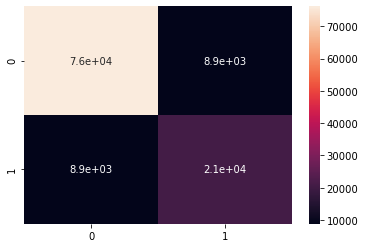

In [28]:
my_pipeline2.fit(X_train, y_train)
predicciones = my_pipeline2.predict(X_test)
cmx = confusion_matrix(y_test,predicciones)

print(f'El accuracy score para el modelo {modelo} es: {accuracy_score(y_test, predicciones)}\n')
print(classification_report(y_test, predicciones)+'\n')
sns.heatmap(cmx, annot=True)
print(cmx)

## Extra trees


In [29]:
modelo = clasificador_extra_trees

In [30]:
my_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', modelo)
                             ])

El accuracy score para el modelo ExtraTreesClassifier(random_state=1234) es: 0.8923550279353956

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     85022
           1       0.80      0.78      0.79     29707

    accuracy                           0.89    114729
   macro avg       0.86      0.85      0.86    114729
weighted avg       0.89      0.89      0.89    114729


[[79336  5686]
 [ 6664 23043]]
El accuracy score para el modelo ExtraTreesClassifier(random_state=1234) es: 0.8923550279353956

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     85022
           1       0.80      0.78      0.79     29707

    accuracy                           0.89    114729
   macro avg       0.86      0.85      0.86    114729
weighted avg       0.89      0.89      0.89    114729


[[79336  5686]
 [ 6664 23043]]
El accuracy score para el modelo ExtraTreesClassifier(random_state=1234) es: 0.892355027

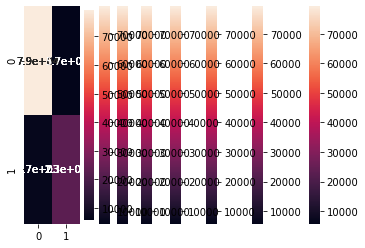

In [31]:
%%timeit
my_pipeline2.fit(X_train, y_train)
predicciones = my_pipeline2.predict(X_test)
cmx = confusion_matrix(y_test,predicciones)

print(f'El accuracy score para el modelo {modelo} es: {accuracy_score(y_test, predicciones)}\n')
print(classification_report(y_test, predicciones)+'\n')
sns.heatmap(cmx, annot=True)
print(cmx)

## Random Forest

In [32]:
modelo = clasificador_random_forest

In [33]:
my_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', modelo)
                             ])

In [34]:
%%timeit
my_pipeline2.fit(X_train, y_train)
predicciones = my_pipeline2.predict(X_test)
cmx = confusion_matrix(y_test,predicciones)

print(f'El accuracy score para el modelo {modelo} es: {accuracy_score(y_test, predicciones)}\n')
print(classification_report(y_test, predicciones)+'\n')
sns.heatmap(cmx, annot=True)
print(cmx)

El accuracy score para el modelo RandomForestClassifier(random_state=1234) es: 0.8949437369801881

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     85022
           1       0.80      0.79      0.80     29707

    accuracy                           0.89    114729
   macro avg       0.86      0.86      0.86    114729
weighted avg       0.89      0.89      0.89    114729


[[79245  5777]
 [ 6276 23431]]
